In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
'''
# download dataset from https://drive.google.com/file/d/1JILW10sr40CRTLiuA1mf__5GBtMDF9xc/view?usp=sharing
!pip install --upgrade gdown
!gdown --id 1JILW10sr40CRTLiuA1mf__5GBtMDF9xc --output vessel_seg.zip
# unzip file
!unzip -q vessel_seg.zip
'''

'\n# download dataset from https://drive.google.com/file/d/1JILW10sr40CRTLiuA1mf__5GBtMDF9xc/view?usp=sharing\n!pip install --upgrade gdown\n!gdown --id 1JILW10sr40CRTLiuA1mf__5GBtMDF9xc --output vessel_seg.zip\n# unzip file\n!unzip -q vessel_seg.zip\n'

In [5]:
# read img and mask
img_paths = glob('/content/drive/MyDrive/all/train/*.tif')
img_path = np.random.choice(img_paths, size=1)[0]
mask_path = img_path.replace('_training.tif', '_manual1.gif')

print('img path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)[:, :, ::-1]
mask = Image.open(mask_path)
mask = np.array(mask)

img path:  /content/drive/MyDrive/all/train/26_training.tif
mask path: /content/drive/MyDrive/all/train/26_manual1.gif


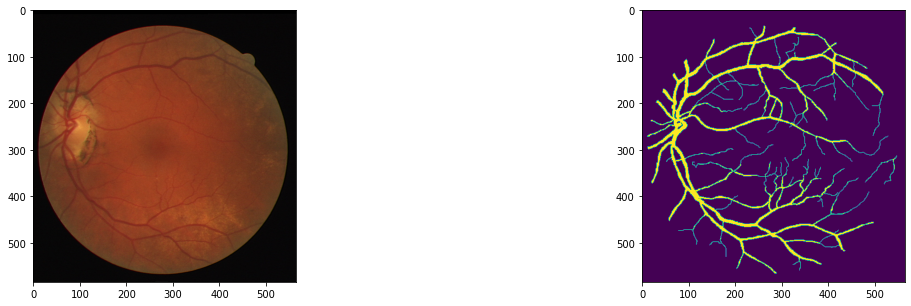

In [6]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [7]:
img.shape, mask.shape

((584, 565, 3), (584, 565))

In [8]:
IMG_SIZE = 512
BS = 4

In [9]:
class DataGenerator(utils.Sequence):
    def __init__(self, img_paths, batch_size, img_size, shuffle=True, mode='train', aug=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.mode = mode
        self.img_paths = img_paths
        self.mask_paths = [p.replace('_training.tif', '_manual1.gif') for p in self.img_paths]
        self.aug = aug
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Affine(
                rotate=(-10, 10), # random rotate -45 ~ +45 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.indexes = np.arange(len(self.mask_paths))
        # data augmentation
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        if self.mode != 'test':
            return X, y
        else:
            return X

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)[:, :,::-1]
            img = self.preprocess(img)
            x[i] = img
            if self.mode != 'test':
                mask = np.array(Image.open(mask_path))
                mask = self.preprocess(mask)
                y[i] = np.expand_dims(mask, axis=-1)
        if self.aug:
          x, y = self.seq(images=x, heatmaps=y)
        return x, y

    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [10]:
all_paths = glob('/content/drive/MyDrive/all/train/*.tif')
test_paths = sorted(glob('/content/drive/MyDrive/all/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)

train_gen = DataGenerator(train_paths, BS, IMG_SIZE, shuffle=True, mode='train', aug=True)
val_gen = DataGenerator(val_paths, BS, IMG_SIZE, shuffle=False, mode='val')
test_gen = DataGenerator(test_paths, BS, IMG_SIZE, shuffle=False, mode='test')

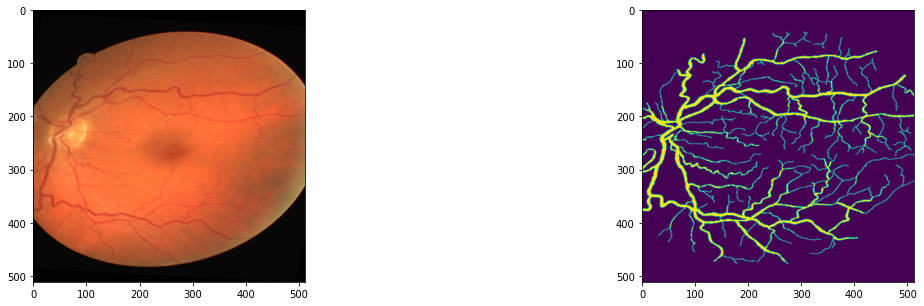

In [11]:
# Check output

batch_x, batch_y = train_gen[0]

batch_i = np.random.choice(len(batch_x))
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(batch_x[batch_i], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(batch_y[batch_i, :, :, 0])
plt.show()

In [12]:
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D(strides=(2,2))(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D(strides=(2,2))(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D(strides=(2,2))(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = layers.concatenate([layers.UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = layers.Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = models.Model(input_layer, output_layer)

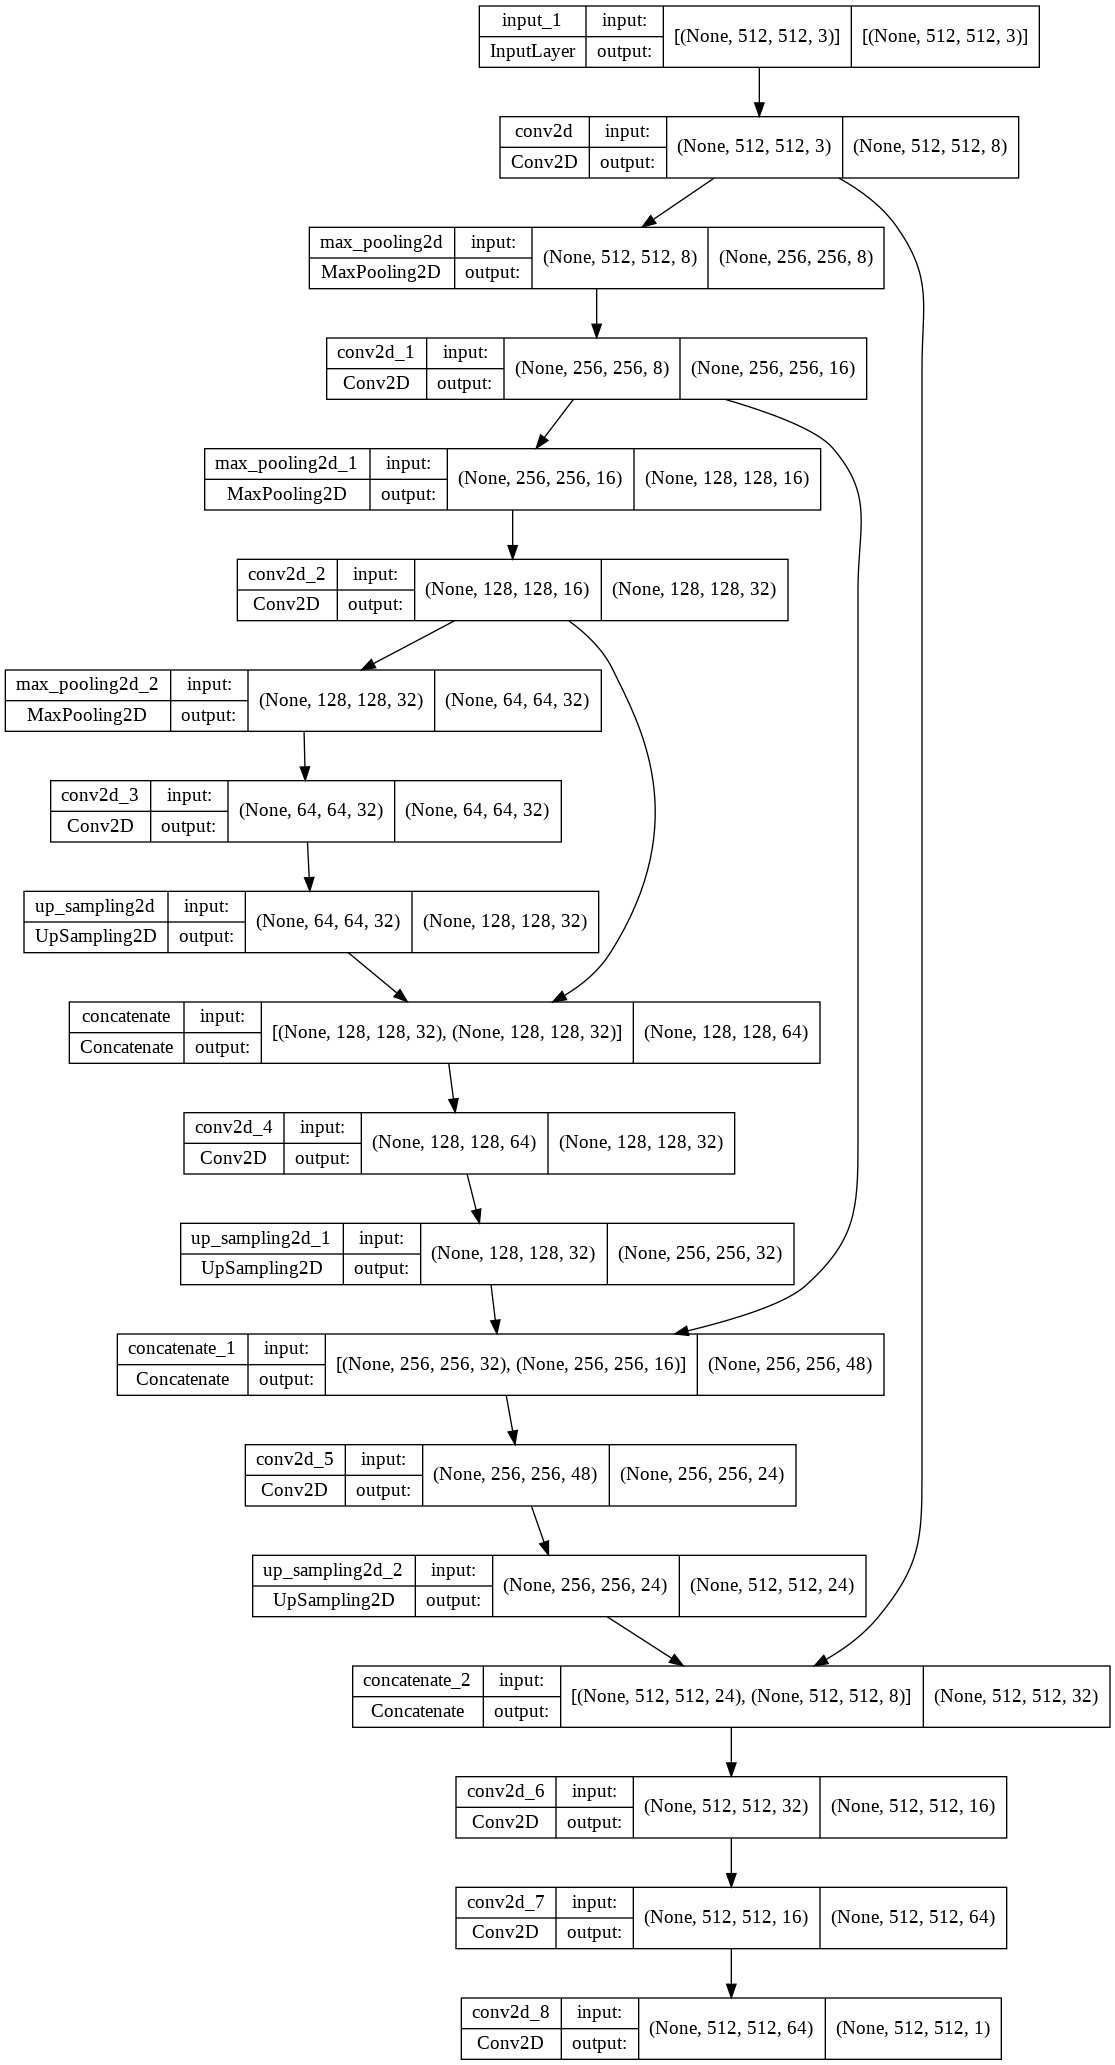

In [13]:
utils.plot_model(model, show_shapes=True)

In [14]:
# Customize Dice coefficient
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [15]:
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=[dice_coef])

In [16]:
weight_saver = callbacks.ModelCheckpoint('/content/drive/MyDrive/seg.h5', monitor='val_dice_coef', mode='max', save_best_only=True)

In [ ]:
model.load_weights('/content/drive/MyDrive/seg.h5')

In [63]:
logs = model.fit(train_gen,
  validation_data = val_gen,
  epochs=500,
  callbacks = [weight_saver])

Epoch 1/500
4/4 [==============================] - 1s 325ms/step - loss: 0.0990 - dice_coef: 0.6706 - val_loss: 0.0988 - val_dice_coef: 0.6690
Epoch 2/500
4/4 [==============================] - 1s 285ms/step - loss: 0.0973 - dice_coef: 0.6592 - val_loss: 0.0951 - val_dice_coef: 0.6750
Epoch 3/500
4/4 [==============================] - 1s 278ms/step - loss: 0.0956 - dice_coef: 0.6727 - val_loss: 0.0956 - val_dice_coef: 0.6761
Epoch 4/500
4/4 [==============================] - 1s 278ms/step - loss: 0.0938 - dice_coef: 0.6655 - val_loss: 0.0957 - val_dice_coef: 0.6682
Epoch 5/500
4/4 [==============================] - 1s 275ms/step - loss: 0.0954 - dice_coef: 0.6618 - val_loss: 0.1008 - val_dice_coef: 0.6692
Epoch 6/500
4/4 [==============================] - 1s 276ms/step - loss: 0.1008 - dice_coef: 0.6726 - val_loss: 0.0944 - val_dice_coef: 0.6816
Epoch 7/500
4/4 [==============================] - 1s 277ms/step - loss: 0.0932 - dice_coef: 0.6676 - val_loss: 0.0987 - val_dice_coef: 0.6666

In [44]:
history = logs.history
val_score = history['val_dice_coef']
max_val_score = max(val_score)
max_val_epochs = val_score.index(max_val_score)+1
print( 'Best val score : ' + str(max_val_score) )
print( 'Best val epoch : ' + str(max_val_epochs) )

Best val score : 0.6889401078224182
Best val epoch : 412


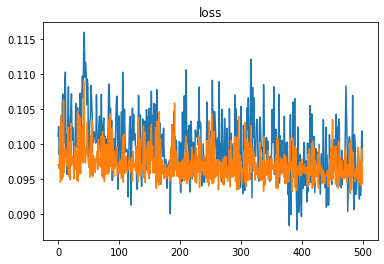

In [45]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.savefig('/content/drive/MyDrive/seg_loss.png')

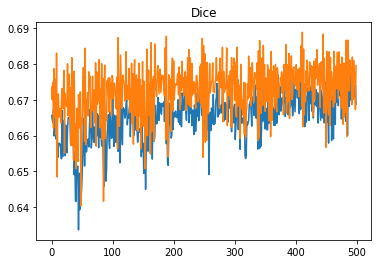

In [46]:
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.savefig('/content/drive/MyDrive/seg_Dice.png')

In [61]:
model_final = models.load_model('/content/drive/MyDrive/seg.h5', compile=False)

0


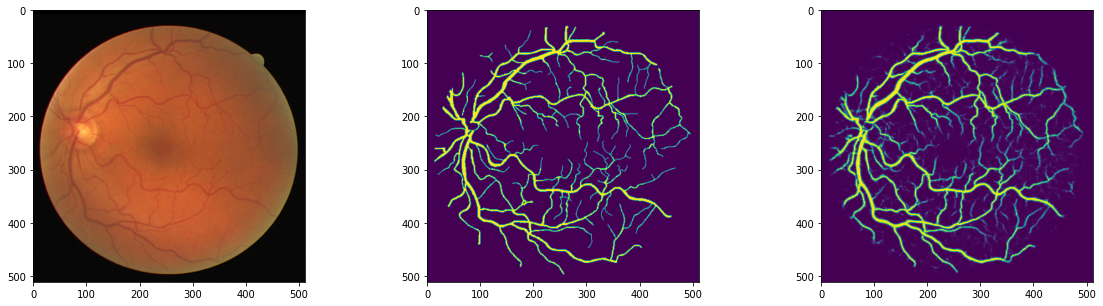

In [48]:
# Sample 1 batch
batch_idx = np.random.randint(len(val_gen))
print(batch_idx)
data = val_gen[batch_idx]
imgs, mask = data # (bs, 512, 512, 3), (bs, 512, 512, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(imgs[img_idx])

# show ground truth & model prediction
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0])
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [49]:
# Displayed with different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[1.14527703e-08, 1.24243726e-08, 2.33984352e-08, ...,
        1.39090986e-07, 1.55935629e-06, 1.29549022e-04],
       [1.01214441e-08, 1.61175144e-08, 3.77739440e-08, ...,
        1.69484750e-07, 1.94526160e-06, 1.28358253e-04],
       [5.99491612e-09, 1.20741310e-08, 2.90891791e-08, ...,
        1.05832406e-07, 1.54535303e-06, 9.15310011e-05],
       ...,
       [6.74304301e-09, 6.68092781e-09, 4.77763162e-09, ...,
        5.27969171e-08, 4.63743930e-07, 3.58935322e-05],
       [3.58587364e-08, 4.66744972e-08, 4.61946499e-08, ...,
        8.99384190e-07, 5.08203539e-06, 2.00634619e-04],
       [5.40890687e-05, 4.67381760e-05, 3.73043440e-05, ...,
        1.60642448e-04, 4.53351007e-04, 4.32358962e-03]], dtype=float32)

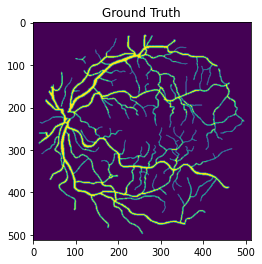

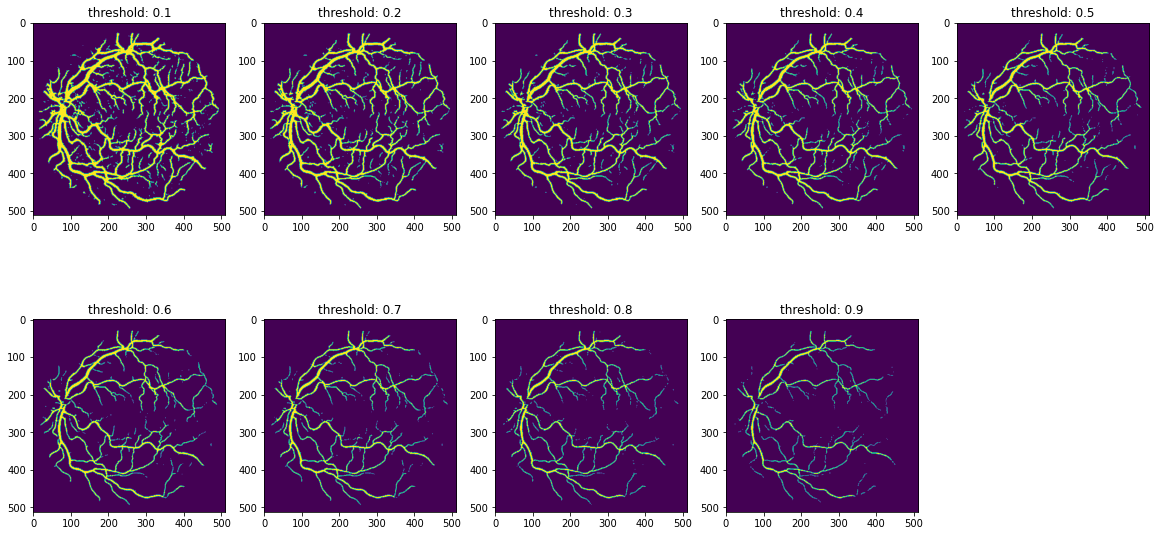

In [50]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()

In [59]:
# make prediction
threshold = 0.4
outputs = []
for i in range(len(test_gen)):
    x_test = test_gen[i]
    y_preds = model_final.predict(x_test)
    y_preds[y_preds <= threshold] = 0
    y_preds[y_preds > threshold] = 1
    for y_pred in y_preds:
        dots = np.where(y_pred.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev +1):
                run_lengths.extend((b+1,0))
            run_lengths[-1] += 1
            prev = b
        output = ' '.join([str(r) for r in run_lengths])
        outputs.append(output)

In [60]:
df = pd.DataFrame(columns=['Id', 'Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv('/content/drive/MyDrive/seg_submission.csv', index=None)
df

,Id,Predicted
0,0,14083 6 14570 2 14596 5 15079 5 15105 11 15140...
1,1,15103 4 15615 5 16127 6 16145 2 16640 6 16657 ...
2,2,12556 3 13068 1 15566 4 15621 3 16078 4 16130 ...
3,3,13047 5 13559 5 14071 5 14584 5 15096 5 15609 ...
4,4,16676 3 17187 5 17698 6 18173 2 18210 6 18683 ...
5,5,17189 5 17701 7 18117 3 18213 7 18628 4 18725 ...
6,6,15591 2 16096 2 16103 2 16609 10 16655 3 17121...
7,7,14568 2 15079 4 15591 5 15635 2 16104 4 16146 ...
8,8,14615 3 15090 1 15126 5 15602 3 15608 3 15634 ...
9,9,15615 3 16128 2 16601 5 16640 2 17113 4 17152 ...
